In [1]:
#This will be used to embed images in Jupyter Notebook

from IPython.display import Image
#While importing this is important to capitalize the I and P in IPython.
#if this is not done then this might be why there is an error


#Importing modules


import sys 
#this is used to manipulate variable and functions. 
#According to online resources this is helpful mostly for run time

import os
#This is useful when dealing with differnent directories in python.
##It can remove, change, or help accese directories

import glob
#This can be helpful when trying to return a file path that follows 
#a specific parttern

from os import listdir
#Shows a file or list of all files and directories that is in a working directory

from os import path
#I am not sure what this one does



#This is for arrays
import numpy as np
import pandas as pd

#For fit files and WCS objects
import astropy.units as u
from astropy.time import Time


#plotting and drawing modules

from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns



#additional libraroes needed for AFINO

from scipy.io import readsav as idlsave

#import stats librarry

import scipy.stats as stats
import scipy.signal as sig

#This is the imports I used for AFINO
from afino import afino_start
from os import listdir
import json
import pandas as pd

In [2]:
def recrate(flx, h): 
    '''compue the difference formula for f'(a) with step size h.
    
    parameters 
    -----------
    flx : array that contains reconnection flux 
    h : contant cadance between observationss
    
    Returns
    ---------
    recreate: reconnection flux(a+h) - reconnection flux(a-h)/2h 
            [negative reconnection rates, posative reconnection rate]
    '''
    
    recreate  = np.zeros((2, len(flx[1,:])))
    
    nflux       = flx[2]
    pflux      = flx[0]
    recreate[0] = np.gradient(nflux, h, edge_order = 2)
    recreate[1] = np.gradient(pflux, h, edge_order = 2) 
    
    return recreate

In [3]:

def check(filename,bstr,wvstr):
    '''
    
    inputs: 
            filename -- name of the reconnection flux idl save file
            bstr     -- 
                        BLOS - normal component taken as the line of sight
                        BRAD - normal component taken as the radial magnatic field (B_r)
            wvstr    -- 
    output: 
            savname  -- full filename with extension of the reconnection flux
    '''
    for i in range(len(bstr)): 
        if path.exists(filename+bstr[i]+wvstr+".sav" ) == True:
            return  filename+bstr[i]+wvstr+".sav"
        else: 
            print('File not found!')
            

In [4]:
def extract_ribbon_vars(idlstrct):
    '''
    Written by Marcel
    Oct. 5, 2020
    Inputs  --
    Outputs --  OPTIONAL (*) 
                *dosday --?
                flx6 -- magnetic reconnection flux for pixel area with I >= median(I)*6
                flx8 -- magnetic reconnection flux for pixel area with I >= median(I)*8
                flx10 -- magnetic reconnection flux for pixel area with I >= median(I)*10
                * area6 --?
                * area8 --? 
                * area10 --?
                * ar_area --? 
                * mflx --?
                tim -- UTC time from HMI 
                * cut --? 
                * sathr --? 
                * str_brad --? 
                * tim_maxnegrecrate --?    
                * tim_maxposrecrate --?       
                * maxnegrecrate --?        
                * maxposrecrate --?         
                n_o_satpix -- number of saturated points for a given AIA image          
                * bcenx6 --?               
                * bceny6 --?             
                * bcenx8 --?            
                * bceny8 --?            
                * bcenx10 --?             
                * bceny10 --?            
                * dst6 --?                
                * dst8 --?               
                * dst10 --?               

                
    
    Extract all the idl variables 
    '''
    
    flx6                = idlstrct.flx6 
    flx8                = idlstrct.flx8
    flx10               = idlstrct.flx10 
    tim                 = list(idlstrct.tim) #object arrays are not suported by python  
    n_o_satpix          = idlstrct.n_o_satpix
    # These have been commented out because they are not used in the qpp analysis 
    dosday              = idlstrct.dosday
    area6               = idlstrct.area6 
    area8               = idlstrct.area8 
    area10              = idlstrct.area10 
    ar_area             = idlstrct.ar_area  
    mflx                = idlstrct.mflx
    cut                 = idlstrct.cut
    satthr              = idlstrct.satthr
    dflxdt              = idlstrct.dflxdt
    str_brad            = idlstrct.str_brad

    tim_maxnegrecrate   = idlstrct.tim_maxnegrecrate 
    tim_maxposrecrate   = idlstrct.tim_maxposrecrate   
    maxnegrecrate       = idlstrct.maxnegrecrate
    maxposrecrate       = idlstrct.maxposrecrate 
    bcenx6              = idlstrct.bcenx6
    bceny6              = idlstrct.bceny6
    bcenx8              = idlstrct.bcenx8
    bceny8              = idlstrct.bceny8
    bcenx10             = idlstrct.bcenx10
    bceny10             = idlstrct.bceny10
    dst6                = idlstrct.dst6
    dst8                = idlstrct.dst8
    dst10               = idlstrct.dst10
    
    return dosday,flx8,flx6,flx10,area6,area8,area10,ar_area,mflx,tim,cut,satthr,dflxdt,str_brad,tim_maxnegrecrate,tim_maxposrecrate,maxnegrecrate,maxposrecrate,n_o_satpix,bcenx6,bceny6,bcenx8,bceny8,bcenx10,bceny10,dst6,dst8,dst10 
    #return dosday,flx8,flx6,flx10,area6,area8,area10,ar_area,mflx,tim,cut,satthr,str_brad,tim_maxnegrecrate,tim_maxposrecrate,maxnegrecrate,maxposrecrate,n_o_satpix,bcenx6,bceny6,bcenx8,bceny8,bcenx10,bceny10,dst6,dst8,dst10 
    #return flx6,flx8,flx10,tim,n_o_satpix,area6,area8,area10,ar_area

In [5]:
def utc2jd(tim): 
    '''
    Written by Marcel 
    Oct. 2020
    
    Imput -- 
                tim -- UTC time from IDL sav file
    Output -- 
                jdt -- Julian days converted from UTC time  
                jst -- Julian days converted into seconds 
                js  -- Seconds from the start of the start date in Julian days
                to  -- Time Object dates in UTC-ISOT format
    '''
    jdt = list(np.zeros(len(tim)))
    jst = list(np.zeros(len(tim)))
    js  = list(np.zeros(len(tim)))
    sts = list(np.zeros(len(tim)))

    for i in range(len(tim)): 
        utcstr = str(tim[i])
        utcstr = utcstr.replace('b',"")
        utcstr = utcstr.replace("'",'') 
        sts[i] = utcstr #array to format date that is read by astropy
        jdt[i] = Time(utcstr,format='isot')
        jdt[i] = jdt[i].jd
        jst[i] = jdt[i] * 24 * 3600
        js[i]  = jst[i] - jst[0]
    jdt = np.array(jdt)
    jst = np.array(jst)
    js  = np.array(js)
    to  = Time(sts,scale='utc',format='isot') 
    return jdt,jst,js,to


In [6]:
def extract_RDB(flare_data):
    #extract all variables from RibbonDB IDL savefiles
    dosday,rdbflx8,rdbflx6,rdbflx10,area6,area8,area10,ar_area,mflx,tim,cut,satthr,dflxdt,str_brad,tim_maxnegrecrate,tim_maxposrecrate,maxnegrecrate,maxposrecrate,n_o_satpix,bcenx6,bceny6,bcenx8,bceny8,bcenx10,bceny10,dst6,dst8,dst10 =extract_ribbon_vars(flare_data)
    #rdbflx6,rdbflx8,rdbflx10,tim,n_o_satpix,area6,area8,area10,ar_area = extract_ribbon_vars(flare_data)
    rdbflx = (rdbflx6+rdbflx10)/2 # reconnection flux in Maxwells
   
    #changes from utc to julian calander (in seconds; see ribbon_functions.py)
    _,_,rdbt,rdbtt = utc2jd(tim) #time is stored in a time stamp from year, month, day, etc...
    
    # Evaluate the reconnection rate
    #   negative recflux = rflx[0,:]    
    #   positive recflux = rflx[1,:]
    rdbrflx  = recrate(rdbflx,rdbt[1]-rdbt[0]) # reconnection rate 
                                               # in units of Maxwells per second
    
    #conversion of time to minutes
    rdbt = rdbt/60
       
    return rdbflx,rdbrflx,rdbt,rdbtt,area8,n_o_satpix,ar_area,maxnegrecrate,maxposrecrate


#(Uses the previously defined functions to convert rdbt data from seconds to minutes)


In [7]:
AFINO_variables = []


In [8]:
import os
names = os.listdir('/Users/veronicaestrada/Downloads/Kazachenko/files/')

In [9]:
short_names = np.zeros(len(names), dtype = 'U30')
for i in range(len(names)):
    short_names[i] = names[i][7:-26]
    print (names[i][7:-26])

20151104_0201_12443_C1.1
20151104_1331_12443_M3.7
20151104_1028_12443_C1.1
20151109_1249_12449_M3.9
20151104_0353_12443_C1.4
20140910_1721_12158_X1.6
20151104_1331_12443_M3.7
20151104_0201_12443_C1.1
20151104_0353_12443_C1.4
20140910_1721_12158_X1.6
20151109_1249_12449_M3.9
20151104_1028_12443_C1.1


In [10]:
exts = [*set(short_names)]
exts

['20151109_1249_12449_M3.9',
 '20151104_0353_12443_C1.4',
 '20140910_1721_12158_X1.6',
 '20151104_1028_12443_C1.1',
 '20151104_0201_12443_C1.1',
 '20151104_1331_12443_M3.7']

/Users/veronicaestrada/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/Users/veronicaestrada/opt/anaconda3/lib/python3.9/site-packages/afino-0.5-py3.9.egg/afino/afino_spectral_models.py:72: RuntimeWarning: invalid value encountered in reciprocal
/Users/veronicaestrada/opt/anaconda3/lib/python3.9/site-packages/afino-0.5-py3.9.egg/afino/afino_spectral_models.py:73: RuntimeWarning: invalid value encountered in reciprocal


 
Analysis summary info:
-----------------------------
 
Lnlike m0 (pow_const): 95.26960940187416
Lnlike m1 (pow_const_gauss): 101.27671435666294
Lnlike m2 (bpow_const): 103.07672472618353
 
BIC m0 (pow_const): -182.75557820752707
BIC m1 (pow_const_gauss): -183.09432722277273
BIC m2 (bpow_const): -190.58616825992456
 
rchi2 m0 (pow_const): 1.406222389770849
prob. m0 (pow_const): 0.15624758517094062
rchi2 m1 (pow_const_gauss): 1.026826143063696
prob. m1 (pow_const_gauss): 0.41888322250753207
rchi2 m2 (bpow_const): 0.8636469705493857
prob. m2 (bpow_const): 0.5779509939787094
 
-----------------------------
 
 


/Users/veronicaestrada/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/Users/veronicaestrada/opt/anaconda3/lib/python3.9/site-packages/afino-0.5-py3.9.egg/afino/afino_spectral_models.py:72: RuntimeWarning: invalid value encountered in reciprocal
/Users/veronicaestrada/opt/anaconda3/lib/python3.9/site-packages/afino-0.5-py3.9.egg/afino/afino_spectral_models.py:73: RuntimeWarning: invalid value encountered in reciprocal
/Users/veronicaestrada/opt/anaconda3/lib/python3.9/site-packages/afino-0.5-py3.9.egg/afino/afino_spectral_models.py:72: RuntimeWarning: overflow encountered in exp
/Users/veronicaestrada/opt/anaconda3/lib/python3.9/site-packages/afino-0.5-py3.9.egg/afino/afino_spectral_models.py:73: RuntimeWarning: overflow encountered in exp


 
Analysis summary info:
-----------------------------
 
Lnlike m0 (pow_const): -1.4412919977276655
Lnlike m1 (pow_const_gauss): 8.631064197623411
Lnlike m2 (bpow_const): 9.492367424751318
 
BIC m0 (pow_const): 8.298684397659752
BIC m1 (pow_const_gauss): -3.7218773897357718
BIC m2 (bpow_const): -8.152534045093796
 
rchi2 m0 (pow_const): 0.9130398193327061
prob. m0 (pow_const): 0.4397057880255818
rchi2 m1 (pow_const_gauss): 0.7968162015568537
prob. m1 (pow_const_gauss): 0.47540644256336284
rchi2 m2 (bpow_const): 0.5825101407776935
prob. m2 (bpow_const): 0.611739061581086
 
-----------------------------
 
 


/Users/veronicaestrada/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/Users/veronicaestrada/opt/anaconda3/lib/python3.9/site-packages/afino-0.5-py3.9.egg/afino/afino_spectral_models.py:72: RuntimeWarning: invalid value encountered in reciprocal
/Users/veronicaestrada/opt/anaconda3/lib/python3.9/site-packages/afino-0.5-py3.9.egg/afino/afino_spectral_models.py:73: RuntimeWarning: invalid value encountered in reciprocal


 
Analysis summary info:
-----------------------------
 
Lnlike m0 (pow_const): 184.79640074354813
Lnlike m1 (pow_const_gauss): 208.30765237901056
Lnlike m2 (bpow_const): 221.13500745983748
 
BIC m0 (pow_const): -360.9846713006879
BIC m1 (pow_const_gauss): -395.0949792920003
BIC m2 (bpow_const): -425.0537545468583
 
rchi2 m0 (pow_const): 1.2579359742597929
prob. m0 (pow_const): 0.20468989711708951
rchi2 m1 (pow_const_gauss): 1.078224410449162
prob. m1 (pow_const_gauss): 0.36802525026012584
rchi2 m2 (bpow_const): 0.7310277997899076
prob. m2 (bpow_const): 0.7778915200263944
 
-----------------------------
 
 


IndexError: index 0 is out of bounds for axis 0 with size 0

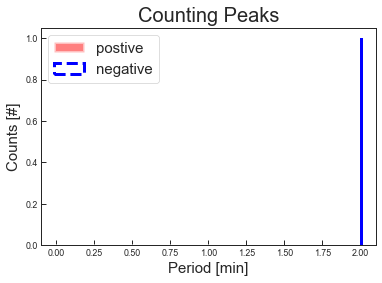

In [11]:
#### Step 2 : Creating new functions 
'''With the help of my amazing Mentor!!! 
Thank you for teaching me important skills'''

for i in range(len(exts)):
    ext = exts[i]
    plotdir = '/Users/veronicaestrada/Downloads/Kazachenko/plots/'
    datadir ="/Users/veronicaestrada/Downloads/Kazachenko/"
    rdbdir  = datadir+'files'


    ##Finds the location of the file and renames it to the date,time, type of flare, and wavelength

    sathr    = [5000.000,4500.000]
    bstr     = ['{:.2f}'.format(sathr[0]) + r"_brad",'{:.2f}'.format(sathr[1]) + r"_brad"]
    wvstr    = r""
    flarename   = check(rdbdir + "/recfile"+ext+r"_cut08_sat",bstr,wvstr) 
    flare_data  = idlsave(flarename,verbose=0) 

    ##what is contained within the variable(flare_data) is dependant on wht I have in my extract_ribbon_vars function. This can all be saved to compare later.

    ####Flux Vs. Time 
    flx8_0 = flare_data.flx8[0] #Posative Flux 
    flx8_2 = flare_data.flx8[2] #Negative Flux

    plt.plot(flx8_0/1e21, label = 'Negative RF',color ='blue' )
    plt.plot(flx8_2/1e21, label= 'Posative RF', color = 'red')
    plt.legend(loc = 'upper right')
    plt.title('Flux Vs. Time',fontsize = 20)
    plt.ylabel('Flux',fontsize = 15)
    plt.xlabel('Time (min)',fontsize = 15)
    plt.legend(fontsize = 15)
    plt.savefig(plotdir+'flux_vs_time/' + ext + '_timeseries.tiff')
    plt.close('all')
    #before exiting plt.close('all')
    
    

    rdbflx,rdbrflx,rdbt,rdbtt,area8,n_o_satpix,ar_area,maxnegrecrate,maxposrecrate = extract_RDB(flare_data)


    ###Posative and negative reconnection rates
    precrate = rdbrflx[0]
    nrecrate = rdbrflx[1]

    ###finds the peaks for the reconnection rate so we can save the Reconnection Rate Vs Time[min]
    posative_peaks = sig.find_peaks(precrate)
    negative_peaks = sig.find_peaks(np.abs(nrecrate))

    peaks_prate = precrate[posative_peaks[0]]
    peaks_ptim = rdbt[posative_peaks[0]]

    peaks_nrate = nrecrate[negative_peaks[0]]
    peaks_ntim = rdbt[negative_peaks[0]]

    ###Plot for Reconnection Rate( Vs. Time (min)

    plt.plot(rdbt,precrate/1e19,color = 'r', alpha = 0.5, linewidth = 2,zorder = 2)
    plt.plot(peaks_ptim,peaks_prate/1e19, 'ro',zorder = 1)


    plt.plot(rdbt,nrecrate/1e19,color = 'b', alpha = 0.5, linewidth = 2,zorder = 2)
    plt.plot(peaks_ntim,peaks_nrate/1e19, 'bo',zorder = 1)
    plt.title('Reconnection Rate Vs. Time',fontsize = 20)
    plt.ylabel('Reconnection Rate ($\\frac{Mx}{s}$)',fontsize = 15)
    plt.xlabel('Time (min)', fontsize =15)
    plt.savefig(plotdir+'timeseries/' + ext + '_timeseries.tiff')
    plt.close('all')
    
    #plotting oscilation period
    
    plt.hist(peaks_ptim[1:-1] - peaks_ptim[0:-2],color = 'red',histtype = 'stepfilled',linewidth = 3,alpha = 0.5, label = 'postive')
    plt.hist(peaks_ntim[1:-1] - peaks_ntim[0:-2],color = 'blue',histtype = 'step',linewidth = 3, linestyle = 'dashed',label = 'negative')
    plt.ylabel('Counts [#]',fontsize = 15)
    plt.xlabel('Period [min]',fontsize = 15)
    plt.title('Counting Peaks', fontsize = 20)
    plt.savefig(plotdir+'counting_peaks/' + ext + '_counting_peaks.tiff')
    plt.legend(fontsize = 15)
    
    #Mode to find the period
    Pmode_Period = stats.mode(peaks_ptim[1:-1] - peaks_ptim[0:-2])[0][0]
    #f'The period of the negative reconnection rate is {stats.mode(peaks_ntim[1:-1] - peaks_ntim[0:-2])[0][0]} minutes')
    
    #mean to find the period 
    mean = np.mean(peaks_ptim[1:-1] - peaks_ptim[0:-2])
    mode = np.mean(peaks_ntim[1:-1] - peaks_ntim[0:-2])
    
    Afino_dir = '/Users/veronicaestrada/afino_repository/saves/'
    #To clean up my laptop
    for f in os.listdir(Afino_dir):
        os.remove(os.path.join(Afino_dir,f))
    
   #To get the RibbonDB time into minutes 
    nAFINO= afino_start.analyse_series(rdbt*60,nrecrate)
    
    #Step 3 (Overwritting the AF_name variable)
    AF_name=listdir(Afino_dir)
    
    #Step 4 (opens the file)
    file = open(Afino_dir+AF_name[0])
    
    #Step 5 (loads the file from step 4)
    AF_dic = json.load(file)
    
    #Step 6 (Easier to work with what is inside of the AF_variable)
    AF_df= pd.DataFrame.from_dict(AF_dic)
    
    #Step 7 (Seperates the models)
    m0 = AF_df['m0']
    m1 = AF_df['m1']
    m2 = AF_df['m2']
    
    #Step 8 Calculate difference in the BIC
    dBIC0 = m1['BIC']- m0['BIC']
    dBIC2 = m1['BIC']- m2['BIC']
    
    #Step 9 Perfered Model between m0 and m1
    if dBIC0 <= -10:
        QPP0 = 1 #There is a QPP
    else:
        QPP0 = 0
        
        #Step 10 perfered model between m1 and m2
    if dBIC2 <= -10:
        QPP2 = 1 #There is a QPP
    else:
        QPP2 = 0 #There is not a QPP
        
    #Step 11 Visulalization 
    dt = (rdbt[1]-rdbt[0])*60 # sampling time of the signal. 
    n = len(nrecrate)
    ### FFT = Normalization Mode "Backwards"
    ### RFFT = Sampling Frequence
    Fcorf = np.fft.rfft(((nrecrate-np.mean(nrecrate))/np.mean(nrecrate))) # The cofficients are complex

    ## Absolute Value 
    Fpowr = np.abs(Fcorf)**2 # We evaluate the complex conjugate which is reffered to as the Power Density


    Ffreq = np.fft.rfftfreq(n,dt) # The frequencies of each given coefficient
    
    plt.loglog(m0['frequencies'],(m0['best_fit_power_spectrum']/np.mean(m0['best_fit_power_spectrum'])),zorder=1, label = 'm0' )
    plt.loglog(m1['frequencies'],(m1['best_fit_power_spectrum']/np.mean(m1['best_fit_power_spectrum'])),zorder=1, label = 'm1')
    plt.loglog(m2['frequencies'],(m2['best_fit_power_spectrum']/np.mean(m2['best_fit_power_spectrum'])), zorder=1, label = 'm2')
    plt.loglog(Ffreq,Fpowr/np.mean(Fpowr),zorder=0,alpha=0.5, label = 'Rec. Rate')
    plt.ylim((1e-3, 1e2))
    plt.title('Fourier Power Model Fitting', fontsize = 20)
    plt.ylabel('Norm. Fourier Power', fontsize = 15)
    plt.xlabel('Frequencey (${Hz}$)', fontsize = 15)
    plt.legend(fontsize= 15)
    plt.savefig(plotdir+'fourier_power_model/' + ext + '_fourier_power_model.tiff')
    plt.close('all')
    
    BIC_m0 = m0['BIC']
    BIC_m1 = m1['BIC']
    BIC_m2 = m2['BIC']
    
    QPP_Period= (1/(np.exp(m1['params'][4])))/60
    
    rchi2_m0 = m0['rchi2']
    rchi2_m1 = m1['rchi2']
    rchi2_m2 = m2['rchi2']
    
    total_nflux = np.min(flx8_0)
    total_pflux = np.max(flx8_2)
    
    total_parea = np.max(area8[0]) #double check 
    total_narea = np.max(area8[2])
    
    total_ar_parea = ar_area[0] #this might be wrong check with marcel
    total_ar_narea = ar_area[1]
    total_n_o_satpix = np.sum(n_o_satpix)
    
    ## Now I can try to save the spacifics
    current_row = [ext,mode,mean, BIC_m0, BIC_m1, BIC_m2,QPP_Period,QPP0,QPP2,rchi2_m0,rchi2_m1,rchi2_m2,total_pflux,total_nflux,total_parea,total_narea,total_ar_parea,total_ar_narea,total_n_o_satpix,maxnegrecrate,maxposrecrate]
    
    AFINO_variables.append(current_row)
   

    
    
    
    #before exiting the for loop plt.close('all')
    #export to spider(it will be faster)


In [ ]:
AFINO_Tabel= pd.DataFrame(AFINO_variables,columns = ['filename','mode','mean','BIC_m0','BIC_m1','BIC_m2','AFINO_Period','QPP0','QPP2','rchi2_m0','rchi2_m1','rchi2_m2','total_pflux','total_nflux','total_parea','total_narea','total_AR_narea','total_AR_narea','n_o_satpix','max_nrecrate','max_precrate'])
AFINO_Tabel.to_csv("AFINO_Tabel.csv",index=False)

In [ ]:
AFINO_Tabel